<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importing-Required-Packages" data-toc-modified-id="Importing-Required-Packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importing Required Packages</a></span></li><li><span><a href="#Importing-Dataset" data-toc-modified-id="Importing-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Importing Dataset</a></span></li><li><span><a href="#Train-Test-Split" data-toc-modified-id="Train-Test-Split-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train Test Split</a></span></li><li><span><a href="#Stationarity" data-toc-modified-id="Stationarity-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Stationarity</a></span><ul class="toc-item"><li><span><a href="#Original-Series-Stationarity-Check" data-toc-modified-id="Original-Series-Stationarity-Check-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Original Series Stationarity Check</a></span></li><li><span><a href="#Transformation-Techniques" data-toc-modified-id="Transformation-Techniques-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Transformation Techniques</a></span><ul class="toc-item"><li><span><a href="#Log-Tranformation" data-toc-modified-id="Log-Tranformation-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Log Tranformation</a></span></li><li><span><a href="#Differencing" data-toc-modified-id="Differencing-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Differencing</a></span></li><li><span><a href="#Log-Transform-followed-by-Differencing" data-toc-modified-id="Log-Transform-followed-by-Differencing-4.2.3"><span class="toc-item-num">4.2.3&nbsp;&nbsp;</span>Log Transform followed by Differencing</a></span></li></ul></li></ul></li><li><span><a href="#Model-Building" data-toc-modified-id="Model-Building-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Building</a></span></li><li><span><a href="#Model-Predictions" data-toc-modified-id="Model-Predictions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Model Predictions</a></span><ul class="toc-item"><li><span><a href="#Train-Once---Predict-Once" data-toc-modified-id="Train-Once---Predict-Once-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Train Once - Predict Once</a></span></li><li><span><a href="#Train-Once---Rolling-Predictions" data-toc-modified-id="Train-Once---Rolling-Predictions-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Train Once - Rolling Predictions</a></span></li><li><span><a href="#Rolling-Training---Rolling-Predictions" data-toc-modified-id="Rolling-Training---Rolling-Predictions-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Rolling Training - Rolling Predictions</a></span></li></ul></li></ul></div>


# Importing Required Packages


In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Importing Dataset


In [118]:
file_path = "nvda.csv"

In [119]:
df = pd.read_csv(file_path)
df = df[["Date", "Close"]]
df.Date = pd.to_datetime(df.Date)
data_backup = df.copy()
df.set_index("Date", inplace=True)

## Analyzing the dataset


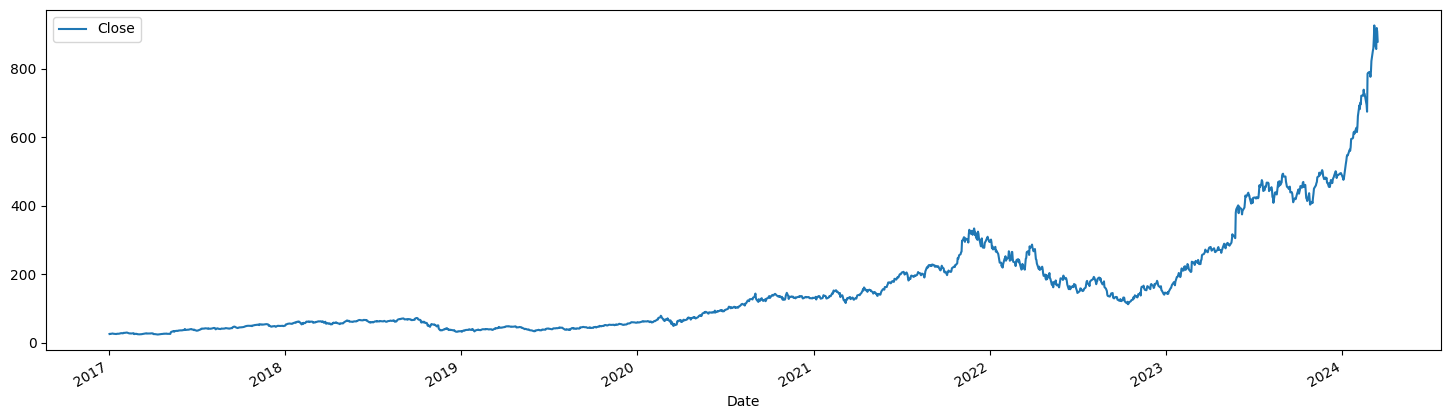

In [120]:
df.plot()
plt.show()

El gráfico sugiere que no hay una estacionalidad evidente y que existe una tendencia a la alza en el precio de la acción de NVDA.
Se identifican fluctuaciones irregulares en el precio de la acción de NVDA. No es por causas aleatorias sino por la creciente demanda de GPUs para la minería de criptomonedas y entrenamiento de modelos LLM.


<Figure size 1000x600 with 0 Axes>

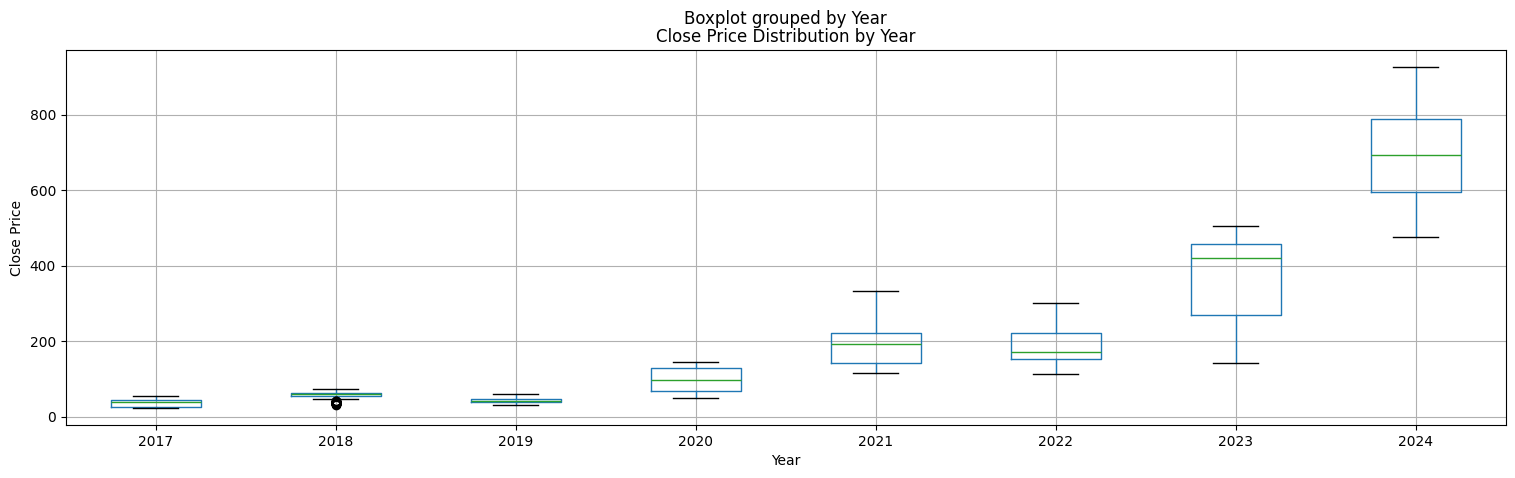

In [129]:
df["Year"] = df.index.year
plt.figure(figsize=(10, 6))
df.boxplot(column="Close", by="Year")
plt.title("Close Price Distribution by Year")
plt.xlabel("Year")
plt.ylabel("Close Price")
plt.show()

Según el comportamiento de los boxplots, se observa que el precio de la acción de NVDA ha ido en aumento a lo largo del tiempo. Y también la varianza ha aumentado a lo largo del tiempo.


### Correlograma


# Train Test Split


In [122]:
test_size = 15
data_backup_length = len(data_backup)

In [123]:
train_df = data_backup.iloc[: data_backup_length - test_size - 1]
test_df = data_backup.iloc[(data_backup_length - test_size) :]
train_df.Date = pd.to_datetime(train_df.Date)
test_df.Date = pd.to_datetime(test_df.Date)
train_df.set_index("Date", inplace=True)
test_df.set_index("Date", inplace=True)
display(train_df.tail())

/var/folders/nz/j6px70h134sbbj9vwy0gpzm40000gn/T/ipykernel_80894/2035563247.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.Date = pd.to_datetime(train_df.Date)
/var/folders/nz/j6px70h134sbbj9vwy0gpzm40000gn/T/ipykernel_80894/2035563247.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.Date = pd.to_datetime(test_df.Date)


,Close
Date,
2024-02-14,739.000000
2024-02-15,726.580017
2024-02-16,726.130005
2024-02-20,694.520020
2024-02-21,674.719971


In [124]:
display(test_df.head())

,Close
Date,
2024-02-23,788.169983
2024-02-26,790.919983
2024-02-27,787.010010
2024-02-28,776.630005
2024-02-29,791.119995


# Stationarity


In this section, we check the series for its stationarity, and transform the series to stationary if it ends up being non stationary. For this a helper function is defined below that plots ACF and PACF plots of the series given to it as input.


In [130]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, zero=False, lags=40, ax=axes[0])
    sgt.plot_pacf(series, zero=False, lags=40, ax=axes[1])

    plt.show()

For checking the stationarity, we plot the **ACF** and **PACF** plots of the series, and run the **ADF** test.


## Original Series Stationarity Check


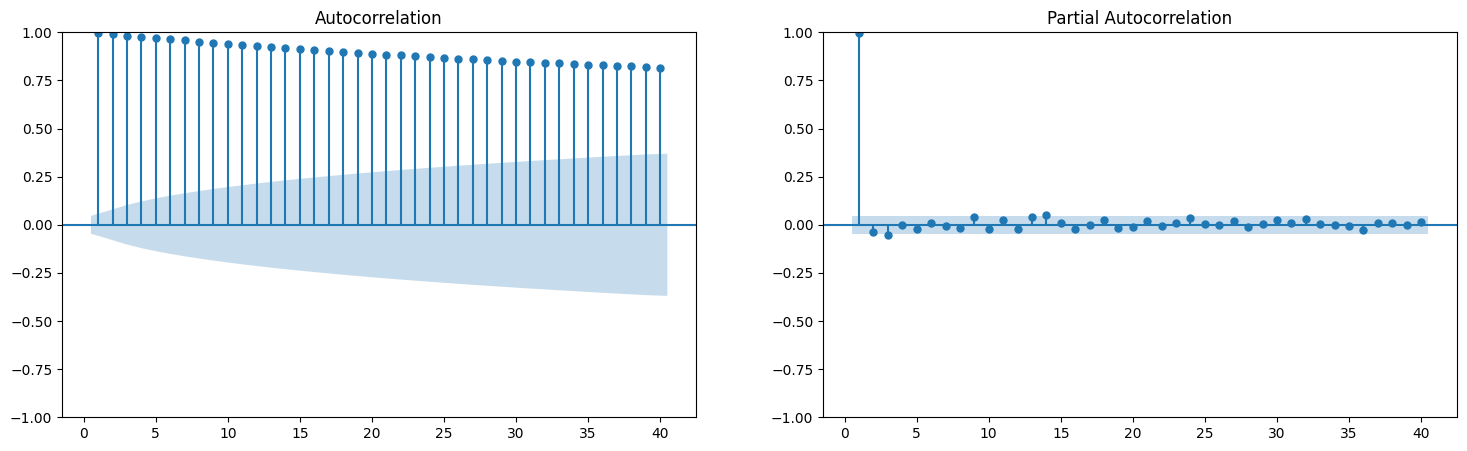

(2.151502804739108,
 0.9988401709675617,
 8,
 1786,
 {'1%': -3.43401669852096,
  '5%': -2.863159643456451,
  '10%': -2.5676322468019896},
 11318.944526177213)

In [135]:
plot_acf_pacf(train_df["Close"])
adfuller(train_df["Close"])

## Transformation Techniques


Clearly this series is **Non-Stationary**. So before applying the ARIMA Models, we tranform this series to Stationary using the following transofrmations.

- **Log Transformation**: Taking the log of each data point will dampen the effect of variance over time
- **Differencing**: Taking the difference between consecutive data points usually removes the trend changes over time.
- **Log Tranformation** followed by **Differencing**: This technique removes both mean and variance changes over time.


To see which tranformation works best for our use case, lets plot the data and its summary statistics over time.


In [127]:
rolling_mean = train_df["spx"].rolling(100).mean()
rolling_var = train_df["spx"].rolling(100).var()

plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(train_df["spx"])
plt.title("SPX Prices", size=24)

plt.subplot(2, 2, 3)
plt.plot(rolling_mean)
plt.title("Rolling Mean (Window = 100)", size=24)

plt.subplot(2, 2, 4)
plt.plot(rolling_var)
plt.title("Rolling Variance (Window = 100)", size=24)

plt.show()

KeyError: 'spx'

From these plots its obvious that the mean and variance in the data varies with respect to time. The 3 transformation techniques listed above are applied in the following cells.


### Log Tranformation


$y\_new_t = \log(y_t)$

where,

- $y\_new_t$: Transformed Series at time $t$
- $y_t$: Original Series at time $t$


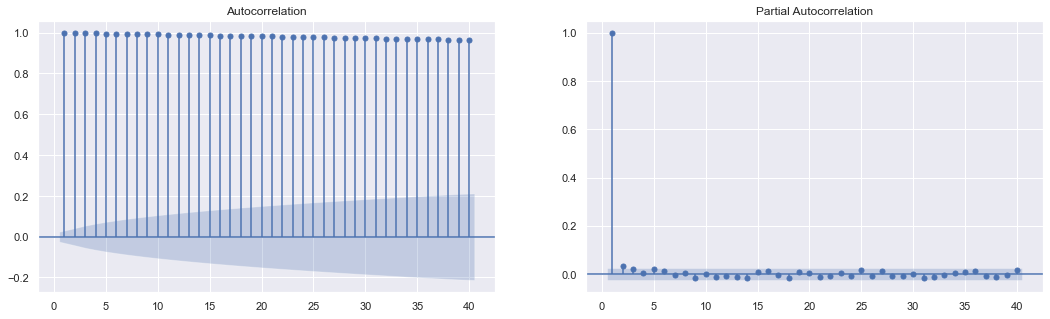

(-1.6251795861696168,
 0.470014901236161,
 35,
 6482,
 {'1%': -3.431359239667287,
  '5%': -2.8619859972456685,
  '10%': -2.5670074010110926},
 -39739.605876021335)

In [ ]:
plot_acf_pacf(np.log(train_df["spx"].values))
adfuller(np.log(train_df["spx"].values))

Using the **Log Transform**, the non stationarity of the dataset could not be removed in this case.


### Differencing


$y\_new_t = y_t - y_{t-1}$

where,

- $y\_new_t$: Transformed Series at time $t$
- $y_t$: Original Series at time $t$
- $y_{t-1}$: Original Series at time $t-1$


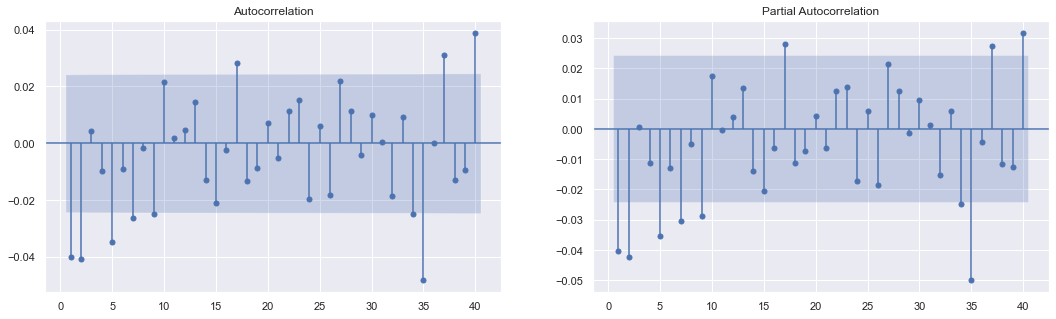

(-27.326250201731206,
 0.0,
 9,
 6507,
 {'1%': -3.4313553606207843,
  '5%': -2.8619842833301883,
  '10%': -2.56700648865667},
 52991.2781500849)

In [ ]:
plot_acf_pacf(train_df["spx"].diff(1).dropna())
adfuller(train_df["spx"].diff(1).dropna())

Clearly the series has been transformed to stationary. But since the variance of the series was also time dependent, transforming the data using **Log Transform** followed by **Differencing** seems ideal.


### Log Transform followed by Differencing


$y\_LT_t = \log(y_t)$<br>
$y\_LT_{t-1} = \log(y_{t-1})$

$y\_new_t = y\_LT_t - y\_LT_{t-1}$<br>
$y\_new_t = \log(y_t) - \log(y_{t-1})$

$\therefore y\_new_t = \log(y_t / y_{t-1})$

where,

- $y\_LT_t$: Log Transformed Series at time $t$
- $y\_LT_{t-1}$: Log Transformed Series at time $t-1$
- $y\_new_t$: Final Differenced Transformed Series at time $t$
- $y_t$: Original Series at time $t$
- $y_{t-1}$: Original Series at time $t-1$


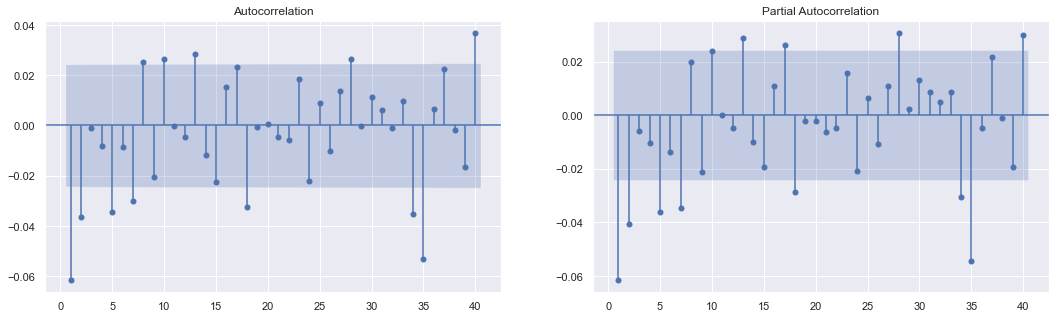

(-14.159576343073565,
 2.0924279253795815e-26,
 34,
 6482,
 {'1%': -3.431359239667287,
  '5%': -2.8619859972456685,
  '10%': -2.5670074010110926},
 -39731.85282267017)

In [ ]:
train_df["spx_log_diff"] = np.log(train_df["spx"].values)
train_df["spx_log_diff"] = train_df["spx_log_diff"].diff(1)

plot_acf_pacf(train_df["spx_log_diff"].dropna())
adfuller(train_df["spx_log_diff"].dropna())

Clearly, this series is stationary and hence, it is the series that will be used to fit the model. Looking at the **ACF** and **PACF** plots for this transformed series, it is reasonalble to start building an **ARMA** Model with the following parameters -

- p = 1 or p = 2 (first 2 lags are significant in PACF plot)
- d = 0 (series is stationary)
- q = 1 or q = 2 (first 2 lags are significant in ACF plot)

If seasonal model (**SARMA**) is to be considered, then the following parameters could be added to the model.

- m = 5 (being a market index, the data is most likely to have weekly repeating patterns as seen in Visualization)
- P = 1 (5th lag is significant in PACF plot)
- D = 0
- Q = 1 (5th lag is significant in ACF plot)


# Model Building


**Non Seasonal Model**

In this model, the **ARMA(1, 1)** Model is build using the **spx_log_diff_seas** series.


In [ ]:
model = SARIMAX(train_df["spx_log_diff"].dropna(), order=(1, 0, 1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           spx_log_diff   No. Observations:                 6517
Model:               SARIMAX(1, 0, 1)   Log Likelihood               19979.741
Date:                Fri, 18 Feb 2022   AIC                         -39953.481
Time:                        18:19:19   BIC                         -39933.135
Sample:                    01-07-1994   HQIC                        -39946.445
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4341      0.073      5.922      0.000       0.290       0.578
ma.L1         -0.4978      0.069     -7.195      0.000      -0.633      -0.362
sigma2         0.0001   9.86e-07    128.998      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             20791.53
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                            -0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Seasonal Model**

In this **SARIMA(1, 0, 1)(1, 0, 1, 5)** Model is built using the **spx_log_diff_seas** series.


In [ ]:
seas_model = SARIMAX(
    train_df["spx_log_diff"].dropna(), order=(1, 0, 1), seasonal_order=(1, 0, 1, 5)
)
seas_model_fit = seas_model.fit()
seas_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                      spx_log_diff   No. Observations:                 6517
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 5)   Log Likelihood               19982.574
Date:                           Thu, 01 Oct 2020   AIC                         -39955.147
Time:                                   18:39:02   BIC                         -39921.236
Sample:                               01-07-1994   HQIC                        -39943.420
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4327      0.075      5.761      0.000       0.286       0.580
ma.L1         -0.4990      0.071     -7.025      0.000      -0.638      -0.360
ar.S.L5        0.1359      0.226      0.601      0.548      -0.308       0.579
ma.S.L5       -0.1636      0.225     -0.727      0.467      -0.605       0.278
sigma2         0.0001   9.86e-07    128.945      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             20440.32
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Based on the **AIC** values of the 2 models, the Non Seasonal Model (**ARMA**) outperforms the Seasonal (**SARMA**) Model. Therefore, for forecasting the prices for the future data (**test_df**) the **ARMA(1, 1)** Model is used.


# Model Predictions


The predictions generated by the above model are not meaningful by themselves. The model is trained on transformed data, and thus, the predicitons are also made on the transformed data. To get meaningful predictions, we have to invert the transformation process.


**Equation for transforming the original series** (refer [this previous transformation section](#Log-Transform-followed-by-Differencing))

$y\_new_t = \log(y_t / y_{t-1})$


**Equation to invert this transformation**

$y_t = y_{t-1}e^{y\_new_t}\tag{*}$


For predicting the future data, the models built in the previous steps can be used in the following 3 ways -

- **Train Once - Predict Once**: In this, we simply forecast for the entire testing period.
- **Train Once - Rolling Predictions**: In this, we forecast for the one testing period. The new data is added for each period to predict the next period from the test set using the same model.
- **Rolling Training - Rolling Predictions**: In this, we forecast for the one testing period. The new data is added for each period to predict the next period from the test set using a newly trained model. The model is trained for each new observed point of the test set.


## Train Once - Predict Once


In this, the model is trained only once, and it is used to forecast into the entire duration of the testing set. Since the ARMA model rely on the past lags, this is a highly inefficient approach. This is because, in this approcah of forecasting, the model uses its own predictions are past lags. So, the errors are compounded and the predictions degreade over time.


Thus, referring to the euation $(*)$, $y_{t-1}$ is the predictions of the model at the previous time step.


In [ ]:
# Building a predictions dataframe for this technique
pred1_df = pd.DataFrame(
    columns=[
        "spx",
        "spx_1",
        "model_preds",
        "model_preds_lower",
        "model_preds_upper",
        "model_preds_exp",
        "model_preds_lower_exp",
        "model_preds_upper_exp",
        "spx_preds",
        "spx_preds_lower",
        "spx_preds_upper",
    ],
    index=data.index,
)

# Storing the original series and one lagged version (y(t) and y(t-1))
pred1_df["spx"] = data["spx"]
pred1_df["spx_1"] = pred1_df["spx"].shift(1)

# Predictions on transformed data over the full span of the dataset.
pred1_df["model_preds"] = model_fit.predict(
    start=train_df.index[1], end=test_df.index[-1]
)

# Getting Confidence Intervals for the transformed predictions on test set
forecast = model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred1_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower spx_log_diff"]
pred1_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper spx_log_diff"]


# Inverting the log transformation by using exponent
pred1_df["model_preds_exp"] = np.exp(pred1_df["model_preds"].values)
pred1_df["model_preds_lower_exp"] = np.exp(list(pred1_df["model_preds_lower"].values))
pred1_df["model_preds_upper_exp"] = np.exp(list(pred1_df["model_preds_upper"].values))

# Building the In Sample predictions using the formula shown in (*)
pred1_df.at[train_df.index, "spx_preds"] = (
    pred1_df.loc[train_df.index]["model_preds_exp"]
    * pred1_df.loc[train_df.index]["spx_1"]
)

# The for loop below is used to get out of sample predictions where y(t-1) are derived from predicted values
pred1_exp_list = list(pred1_df.loc[test_df.index]["model_preds_exp"].values)
y_t_1 = pred1_df.at[train_df.index[-1], "spx_preds"]
for idx, pred_exp in enumerate(pred1_exp_list):
    pred1_df.at[test_df.index[idx], "spx_preds"] = (
        pred1_df.at[test_df.index[idx], "model_preds_exp"] * y_t_1
    )
    y_t_1 = pred1_df.at[test_df.index[idx], "spx_preds"]

# Inverting the Transformation on the confidence intervals using the formula in (*)
pred1_df.at[test_df.index, "spx_preds_lower"] = (
    pred1_df.loc[test_df.index]["model_preds_lower_exp"]
    * pred1_df.loc[test_df.index]["spx_preds"]
)
pred1_df.at[test_df.index, "spx_preds_upper"] = (
    pred1_df.loc[test_df.index]["model_preds_upper_exp"]
    * pred1_df.loc[test_df.index]["spx_preds"]
)

Exploring the first few rows of this predictions dataframe


In [ ]:
pred1_df.head()

,spx,spx_1,model_preds,model_preds_lower,model_preds_upper,model_preds_exp,model_preds_lower_exp,model_preds_upper_exp,spx_preds,spx_preds_lower,spx_preds_upper
Date,,,,,,,,,,,
1994-01-06,467.119995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-07,469.899994,467.119995,0.000000,NaN,NaN,1.000000,NaN,NaN,467.12,NaN,NaN
1994-01-10,475.269989,469.899994,-0.000363,NaN,NaN,0.999637,NaN,NaN,469.73,NaN,NaN
1994-01-11,474.130005,475.269989,-0.000896,NaN,NaN,0.999104,NaN,NaN,474.844,NaN,NaN
1994-01-12,474.170013,474.130005,-0.000294,NaN,NaN,0.999706,NaN,NaN,473.991,NaN,NaN


**Evaluating Model Performance**


- **In Sample and Out of Sample Fit**


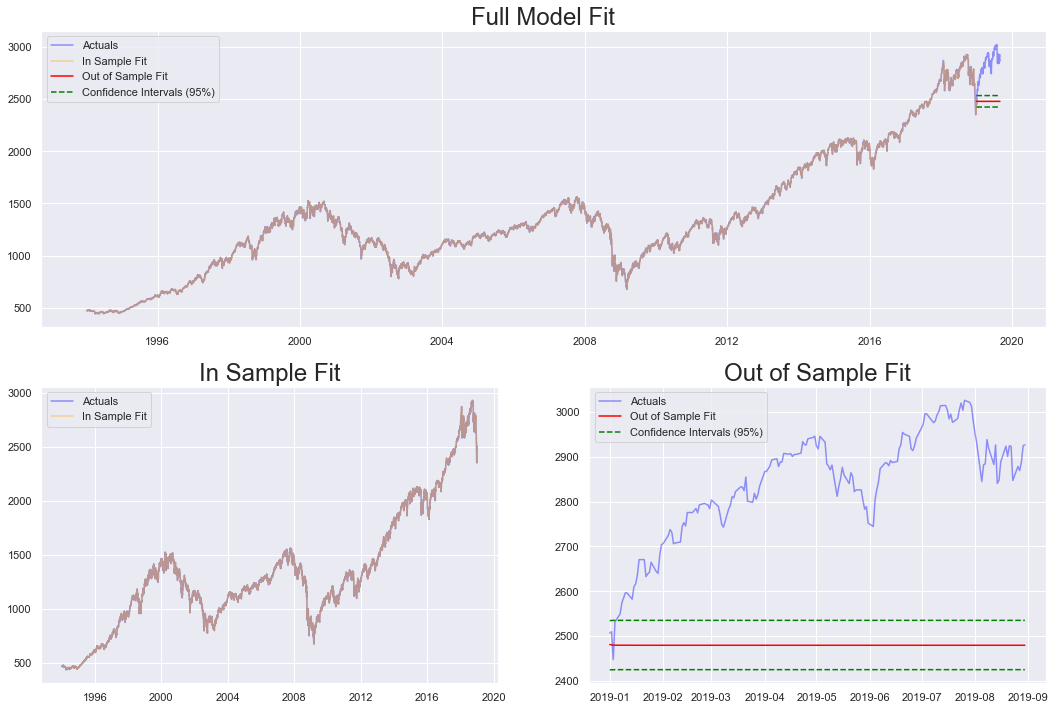

In [ ]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred1_df["spx"], color="blue", label="Actuals", alpha=0.4)
plt.plot(
    pred1_df.loc[train_df.index]["spx_preds"],
    color="orange",
    alpha=0.4,
    linestyle="-",
    label="In Sample Fit",
)
plt.plot(
    pred1_df.loc[test_df.index]["spx_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)
plt.plot(
    pred1_df.loc[test_df.index]["spx_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
)
plt.plot(pred1_df.loc[test_df.index]["spx_preds_upper"], color="green", linestyle="--")
plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred1_df.loc[train_df.index]["spx"], color="blue", label="Actuals", alpha=0.4)
plt.plot(
    pred1_df.loc[train_df.index]["spx_preds"],
    color="orange",
    alpha=0.4,
    linestyle="-",
    label="In Sample Fit",
)
plt.title("In Sample Fit", size=24)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(pred1_df.loc[test_df.index]["spx"], color="blue", label="Actuals", alpha=0.4)
plt.plot(
    pred1_df.loc[test_df.index]["spx_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)
plt.plot(
    pred1_df.loc[test_df.index]["spx_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
)
plt.plot(pred1_df.loc[test_df.index]["spx_preds_upper"], color="green", linestyle="--")
plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

- **Root Mean Squared Error**


In [ ]:
rmse_in = np.sqrt(
    mean_squared_error(
        y_true=pred1_df.loc[train_df.index[1] : train_df.index[-1]]["spx"],
        y_pred=pred1_df.loc[train_df.index[1] : train_df.index[-1]]["spx_preds"],
    )
)

rmse_out = np.sqrt(
    mean_squared_error(
        y_true=pred1_df.loc[test_df.index]["spx"],
        y_pred=pred1_df.loc[test_df.index]["spx_preds"],
    )
)

print(f"RMSE for In Sample Fit - {rmse_in}")
print(f"RMSE for In Sample Fit - {rmse_out}")

RMSE for In Sample Fit - 14.400974715921475
RMSE for In Sample Fit - 378.1531600583386


Clearly, the out of sample fit is really poor in this approach. Thus this model is not realiable for forecasting for a very long time in the future.


## Train Once - Rolling Predictions


In this, the model is trained only once, and it is used to forecast into the entire duration of the testing set. However, unlike the last approach, the previous lags for the predictions are taken from the observations in the test set itself. In practice, this means that the value forecasted for tomorrow will be derived from the actual observation made today. Since the lags are much more reliable in this case, the model will perform much better. On the other hand, this approach cannot be used to forecast for longer durations as it needs real o=past observations to build forecasts.


Thus, referring to the euation $(*)$, $y_{t-1}$ is the actual observation from the test set at the previous time step.


In [ ]:
# Building a predictions dataframe for this technique
pred2_df = pd.DataFrame(
    columns=[
        "spx",
        "spx_1",
        "model_preds",
        "model_preds_lower",
        "model_preds_upper",
        "model_preds_exp",
        "model_preds_lower_exp",
        "model_preds_upper_exp",
        "spx_preds",
        "spx_preds_lower",
        "spx_preds_upper",
    ],
    index=data.index,
)

# Storing the original series and one lagged version (y(t) and y(t-1))
pred2_df["spx"] = data["spx"]
pred2_df["spx_1"] = pred2_df["spx"].shift(1)

# Predictions on transformed data over the full span of the dataset.
pred2_df["model_preds"] = model_fit.predict(
    start=train_df.index[1], end=test_df.index[-1]
)

# Getting Confidence Intervals for the transformed predictions on test set
forecast = model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred2_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower spx_log_diff"]
pred2_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper spx_log_diff"]


# Building the In Sample and Out of Sample predictions using the formula shown in (*)
# Taking Exponent to invert logarithmic effect
pred2_df["model_preds_exp"] = np.exp(pred2_df["model_preds"].values)
pred2_df["model_preds_lower_exp"] = np.exp(list(pred2_df["model_preds_lower"].values))
pred2_df["model_preds_upper_exp"] = np.exp(list(pred2_df["model_preds_upper"].values))

# Multiplying with past lags to get the forecast and the confidence intervals
pred2_df["spx_preds"] = pred2_df["model_preds_exp"] * pred2_df["spx_1"]
pred2_df.at[test_df.index, "spx_preds_lower"] = (
    pred2_df.loc[test_df.index]["model_preds_lower_exp"]
    * pred2_df.loc[test_df.index]["spx_1"]
)
pred2_df.at[test_df.index, "spx_preds_upper"] = (
    pred2_df.loc[test_df.index]["model_preds_upper_exp"]
    * pred2_df.loc[test_df.index]["spx_1"]
)

Exploring a few rows of this dataframe


In [ ]:
pred2_df.head()

,spx,spx_1,model_preds,model_preds_lower,model_preds_upper,model_preds_exp,model_preds_lower_exp,model_preds_upper_exp,spx_preds,spx_preds_lower,spx_preds_upper
Date,,,,,,,,,,,
1994-01-06,467.119995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-07,469.899994,467.119995,0.000000,NaN,NaN,1.000000,NaN,NaN,467.119995,NaN,NaN
1994-01-10,475.269989,469.899994,-0.000363,NaN,NaN,0.999637,NaN,NaN,469.729528,NaN,NaN
1994-01-11,474.130005,475.269989,-0.000896,NaN,NaN,0.999104,NaN,NaN,474.844177,NaN,NaN
1994-01-12,474.170013,474.130005,-0.000294,NaN,NaN,0.999706,NaN,NaN,473.990819,NaN,NaN


**Evaluating Model Performance**


- **In Sample and Out of Sample Fit**


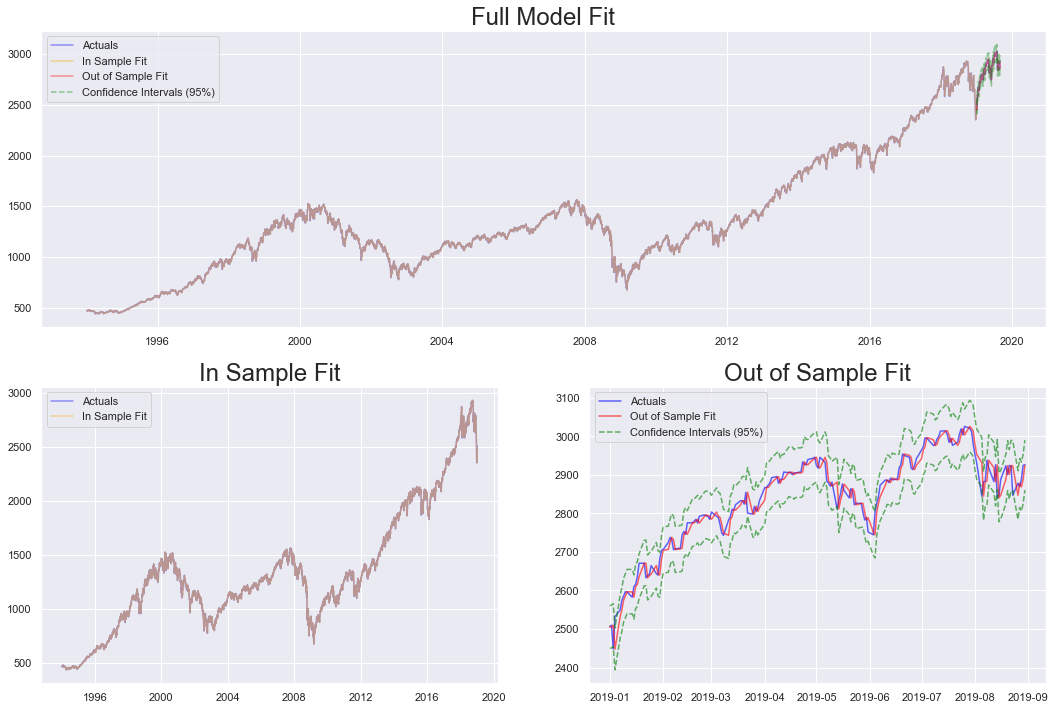

In [ ]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred2_df["spx"], color="blue", label="Actuals", alpha=0.4)
plt.plot(
    pred2_df.loc[train_df.index]["spx_preds"],
    color="orange",
    alpha=0.4,
    linestyle="-",
    label="In Sample Fit",
)
plt.plot(
    pred2_df.loc[test_df.index]["spx_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.4,
)
plt.plot(
    pred2_df.loc[test_df.index]["spx_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)
plt.plot(
    pred2_df.loc[test_df.index]["spx_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)
plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred2_df.loc[train_df.index]["spx"], color="blue", label="Actuals", alpha=0.4)
plt.plot(
    pred2_df.loc[train_df.index]["spx_preds"],
    color="orange",
    linestyle="-",
    label="In Sample Fit",
    alpha=0.4,
)
plt.title("In Sample Fit", size=24)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(pred2_df.loc[test_df.index]["spx"], color="blue", label="Actuals", alpha=0.6)
plt.plot(
    pred2_df.loc[test_df.index]["spx_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)
plt.plot(
    pred2_df.loc[test_df.index]["spx_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)
plt.plot(
    pred2_df.loc[test_df.index]["spx_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)
plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

- **Root Mean Squared Error**


In [ ]:
rmse_in = np.sqrt(
    mean_squared_error(
        y_true=pred2_df.loc[train_df.index[1] : train_df.index[-1]]["spx"],
        y_pred=pred2_df.loc[train_df.index[1] : train_df.index[-1]]["spx_preds"],
    )
)

rmse_out = np.sqrt(
    mean_squared_error(
        y_true=pred2_df.loc[test_df.index]["spx"],
        y_pred=pred2_df.loc[test_df.index]["spx_preds"],
    )
)

print(f"RMSE for In Sample Fit - {rmse_in}")
print(f"RMSE for In Sample Fit - {rmse_out}")

RMSE for In Sample Fit - 14.400974715921475
RMSE for In Sample Fit - 24.053094799484253


The **RMSE** value clearly indicate that this model is very powerful in modeliing **In sample** and **Out of Sample** Data. However, the drawback is that it needs past values for each forecast and can hence only forecast for one time step in the future.


## Rolling Training - Rolling Predictions


In this, the model is trained only once, and it is used to forecast for one lag in the future. Then the actual observation for this lag is added to the training set, the model is retrained and the new model is used to forecast for the next lag. This is the most computationaly expensive approach. However, it is the most suited to capture trend changes in the forecasting period.


Thus, referring to the euation $(*)$, $y_{t-1}$ is the actual observation from the test set at the previous time step.


The function below takes in the prediction dataframe as the input, and the indices till which the model should be trained and for which the forecasts should be made. It outputs the prediction and the confidence intervals for the corresponding forecast in the test set.


In [ ]:
def get_model(rolling_train_df, last_idx, next_i):
    train_series = rolling_train_df.loc[:last_idx]["spx"]
    train_series = np.log(train_series)
    train_series = train_series.diff(1)
    flag = 0
    while flag == 0:
        flag = 0
        try:
            rolling_model = SARIMAX(train_series.dropna(), order=(1, 0, 1))
            rolling_model_results = rolling_model.fit()
            flag = 1
        except:
            flag = 0

    rolling_pred = rolling_model_results.predict(
        start=test_df.index[next_i], end=test_df.index[next_i]
    )

    rolling_forecast = rolling_model_results.get_forecast(1)
    rolling_forecast_df = rolling_forecast.conf_int(
        alpha=0.05
    )  # Confidence level of 95%

    y_t_pred = (
        np.exp(rolling_pred.values[0])
        * rolling_train_df.at[test_df.index[next_i], "spx_1"]
    )
    y_t_pred_lower = (
        np.exp(rolling_forecast_df["lower spx"].values[0])
        * rolling_train_df.at[test_df.index[next_i], "spx_1"]
    )
    y_t_pred_upper = (
        np.exp(rolling_forecast_df["upper spx"].values[0])
        * rolling_train_df.at[test_df.index[next_i], "spx_1"]
    )

    return rolling_model_results, y_t_pred, y_t_pred_lower, y_t_pred_upper

In [ ]:
# Building a predictions dataframe for this technique
pred3_df = pd.DataFrame(
    columns=[
        "spx",
        "spx_1",
        "model_preds",
        "model_preds_lower",
        "model_preds_upper",
        "model_preds_exp",
        "model_preds_lower_exp",
        "model_preds_upper_exp",
        "spx_preds",
        "spx_preds_lower",
        "spx_preds_upper",
    ],
    index=data.index,
)

# Storing the original series and one lagged version (y(t) and y(t-1))
pred3_df["spx"] = data["spx"]
pred3_df["spx_1"] = pred3_df["spx"].shift(1)

# Predictions on transformed data over the full training dataset and the first lag of the test dataset.
pred3_df["model_preds"] = model_fit.predict(
    start=train_df.index[1], end=test_df.index[0]
)

# Taking Exponent to invert logarithmic effect from predictions
pred3_df["model_preds_exp"] = np.exp(pred3_df["model_preds"].values)

# Building the In Sample Predictions
pred3_df.at[train_df.index, "spx_preds"] = (
    pred3_df.loc[train_df.index]["model_preds_exp"]
    * pred3_df.loc[train_df.index]["spx_1"]
)
# pred3_df.at[train_df.index, "spx_preds"] = pred3_df.loc[train_df.index]["model_preds_exp"] * pred3_df.loc[train_df.index]["spx_1"]

# The prediction for the first testing lag is built here
last_train_idx = train_df.index[-1]
rolling_model, y_t_pred, y_t_pred_lower, y_t_pred_upper = get_model(
    pred3_df, last_train_idx, 0
)
pred3_df.at[test_df.index[0], "spx_preds"] = y_t_pred
pred3_df.at[test_df.index[0], "spx_preds_lower"] = y_t_pred_lower
pred3_df.at[test_df.index[0], "spx_preds_upper"] = y_t_pred_upper

# This loop is used to get new models for each new lag that is added to the training set from the testing set.
for idx in range(len(test_df.index) - 1):
    last_train_idx = test_df.index[idx]
    rolling_model, y_t_pred, y_t_pred_lower, y_t_pred_upper = get_model(
        pred3_df, last_train_idx, idx + 1
    )
    pred3_df.at[test_df.index[idx + 1], "spx_preds"] = y_t_pred
    pred3_df.at[test_df.index[idx + 1], "spx_preds_lower"] = y_t_pred_lower
    pred3_df.at[test_df.index[idx + 1], "spx_preds_upper"] = y_t_pred_upper

In [ ]:
pred3_df.at[train_df.index, "spx_preds"] = (
    pred3_df.loc[train_df.index]["model_preds_exp"]
    * pred3_df.loc[train_df.index]["spx_1"]
)

Exploring the first few rows of this dataframe


In [ ]:
pred3_df.head()

,spx,spx_1,model_preds,model_preds_lower,model_preds_upper,model_preds_exp,model_preds_lower_exp,model_preds_upper_exp,spx_preds,spx_preds_lower,spx_preds_upper
Date,,,,,,,,,,,
1994-01-06,467.119995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-07,469.899994,467.119995,0.000000,NaN,NaN,1.000000,NaN,NaN,467.12,NaN,NaN
1994-01-10,475.269989,469.899994,-0.000363,NaN,NaN,0.999637,NaN,NaN,469.73,NaN,NaN
1994-01-11,474.130005,475.269989,-0.000896,NaN,NaN,0.999104,NaN,NaN,474.844,NaN,NaN
1994-01-12,474.170013,474.130005,-0.000294,NaN,NaN,0.999706,NaN,NaN,473.991,NaN,NaN


**Evaluating Model Performance**


- **In Sample and Out of Sample Fit**


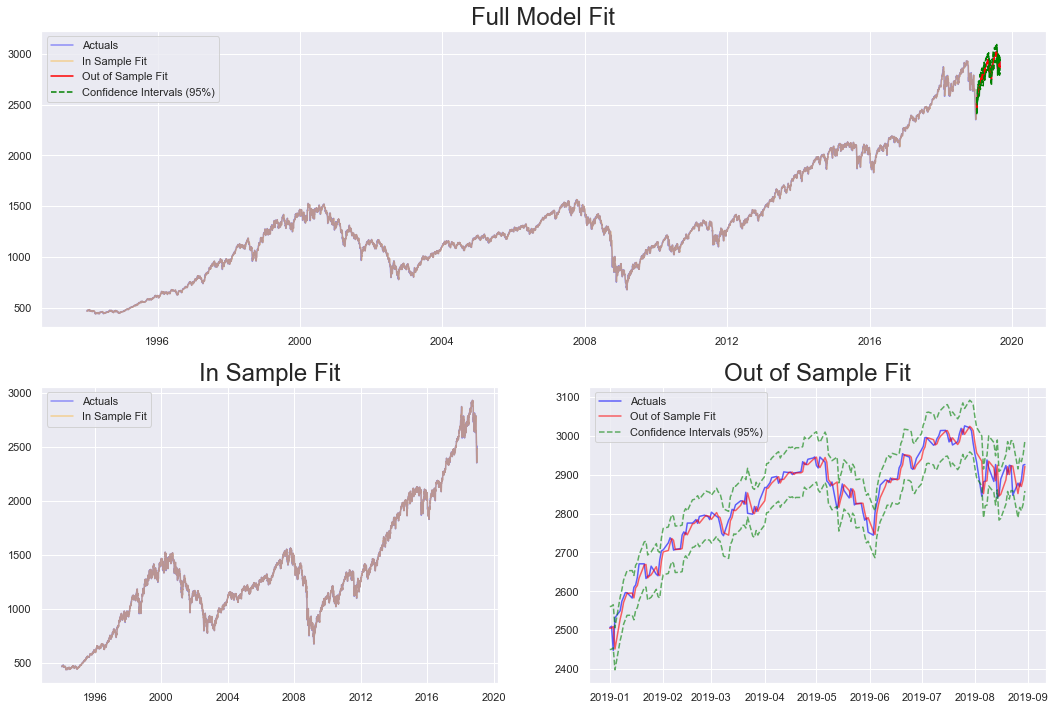

In [ ]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred3_df["spx"], color="blue", label="Actuals", alpha=0.4)
plt.plot(
    pred3_df.loc[train_df.index]["spx_preds"],
    color="orange",
    alpha=0.4,
    linestyle="-",
    label="In Sample Fit",
)
plt.plot(
    pred3_df.loc[test_df.index]["spx_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)
plt.plot(
    pred3_df.loc[test_df.index]["spx_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
)
plt.plot(pred3_df.loc[test_df.index]["spx_preds_upper"], color="green", linestyle="--")
plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred3_df.loc[train_df.index]["spx"], color="blue", label="Actuals", alpha=0.4)
plt.plot(
    pred3_df.loc[train_df.index]["spx_preds"],
    color="orange",
    linestyle="-",
    label="In Sample Fit",
    alpha=0.4,
)
plt.title("In Sample Fit", size=24)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(pred3_df.loc[test_df.index]["spx"], color="blue", label="Actuals", alpha=0.6)
plt.plot(
    pred3_df.loc[test_df.index]["spx_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)
plt.plot(
    pred3_df.loc[test_df.index]["spx_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)
plt.plot(
    pred3_df.loc[test_df.index]["spx_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)
plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

- **Root Mean Squared Error**


In [ ]:
rmse_in = np.sqrt(
    mean_squared_error(
        y_true=pred3_df.loc[train_df.index[1] : train_df.index[-1]]["spx"],
        y_pred=pred3_df.loc[train_df.index[1] : train_df.index[-1]]["spx_preds"],
    )
)

rmse_out = np.sqrt(
    mean_squared_error(
        y_true=pred3_df.loc[test_df.index]["spx"],
        y_pred=pred3_df.loc[test_df.index]["spx_preds"],
    )
)

print(f"RMSE for In Sample Fit - {rmse_in}")
print(f"RMSE for In Sample Fit - {rmse_out}")

RMSE for In Sample Fit - 14.400974715921475
RMSE for In Sample Fit - 23.97736346969371


This approach clearly outperforms the other 2. However, the time spent on forecasting is much higher than that spent in the previous method, and the **RMSE** value of the 2 approches are very similar. Thus, it makes more sense to forecast using the previous approach (especially when there are no major trend changes).
